# Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info

<bound method DataFrame.info of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Cleaning and Feature Engineering

In [3]:
df = df.drop(['isFlaggedFraud'], axis = 1)
df = df.drop(['nameOrig'], axis = 1)
df = df.drop(['nameDest'], axis = 1)
df = df.drop_duplicates()

In [4]:
df['hour'] = df['step'] % 24
df['types'] = df['type']
df = df.drop(['step'], axis=1)
df['no_money_after_trasaction'] = (df['newbalanceOrig'] <= 1e-3).astype(int)
df2 = df.copy()
df = pd.get_dummies(df, columns=['type'], drop_first=False)

# Exploratory Analysis

In [5]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,types,no_money_after_trasaction,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,1,PAYMENT,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,1,PAYMENT,0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,1,TRANSFER,1,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,1,CASH_OUT,1,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,1,PAYMENT,0,0,0,0,1,0


In [10]:
total_transactions = len(df)
num_frauds = df['isFraud'].sum()
percent_frauds = (num_frauds / total_transactions) * 100

print(f"Total transactions: {total_transactions:,}")
print(f"Total frauds: {num_frauds:,}")
print(f"Percentage of frauds: {percent_frauds:.4f}%")


Total transactions: 6,362,077
Total frauds: 8,197
Percentage of frauds: 0.1288%


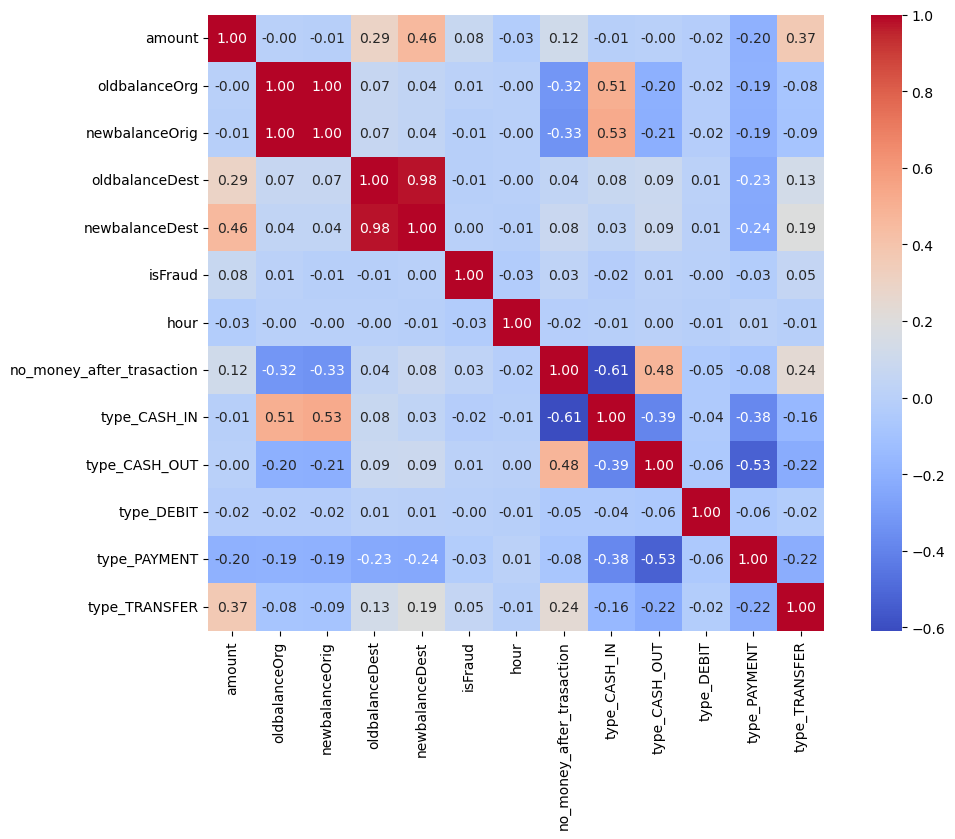

In [6]:
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.show()

In [16]:
df2.groupby('type')['isFraud'].sum().reset_index()

,type,isFraud
0,CASH_IN,0
1,CASH_OUT,4100
2,DEBIT,0
3,PAYMENT,0
4,TRANSFER,4097


C:\Users\andre\AppData\Local\Temp\ipykernel_18592\2311334645.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_summary, x='type', y='isFraud', palette='Reds_r')


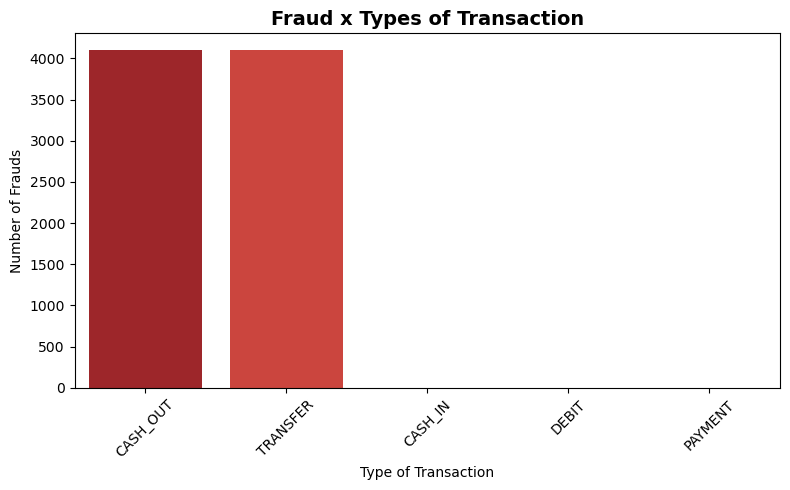

In [17]:
fraud_counts = df2.groupby('type')['isFraud'].sum().reset_index()
total_counts = df2['type'].value_counts().reset_index()
total_counts.columns = ['type', 'total_transacoes']

fraud_summary = pd.merge(fraud_counts, total_counts, on='type', how='outer').fillna(0)
fraud_summary['isFraud'] = fraud_summary['isFraud'].astype(int)

fraud_summary = fraud_summary.sort_values('isFraud', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=fraud_summary, x='type', y='isFraud', palette='Reds_r')

plt.title('Fraud x Types of Transaction', fontsize=14, fontweight='bold')
plt.xlabel('Type of Transaction')
plt.ylabel('Number of Frauds')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
frauds = df[df['isFraud'] == 1]

count_no_money = frauds['no_money_after_trasaction'].value_counts()

print("Counting frauds with and without money after the transaction:")
print(count_no_money)

percents = (count_no_money / count_no_money.sum()) * 100
print("\nPercentual:")
print(percents.round(2))


Counting frauds with and without money after the transaction:
1    8037
0     160
Name: no_money_after_trasaction, dtype: int64

Percentual:
1    98.05
0     1.95
Name: no_money_after_trasaction, dtype: float64


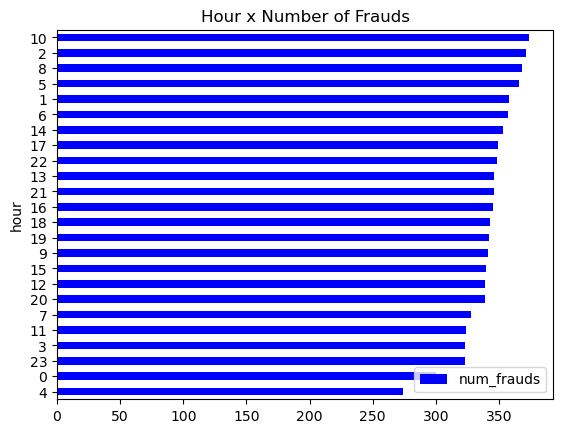

In [28]:
df['hour'] = df['hour'].astype(int)

fraud_by_hour = (
    df[df['isFraud'] == 1]['hour']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'hour', 'hour': 'num_frauds'})
    .sort_values('num_frauds', ascending=True)
)

fraud_by_hour.plot.barh(x='hour', y='num_frauds', color='blue')

plt.title("Hour x Number of Frauds")
plt.show()

In [29]:
# Since the hour isn't important, I'll delete it
df = df.drop(['hour'], axis = 1)
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,no_money_after_trasaction,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,1,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,1,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [30]:
df.to_csv('treated_data.csv')